<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Comparative Study of Latest Models for TwitterSentiment Analysis (Assignment2)


In [1]:
# Silent installation  
!pip install -U tensorflow zhon transformers sentencepiece &> /dev/null
# Download dataset and lib files from the github
!git clone https://github.com/cardiffnlp/tweeteval.git &> /dev/null
!git clone https://github.com/gibsonx/grocery.git &> /dev/null

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,confusion_matrix,f1_score

#Import customized classes and libraries from file
sys.path.insert(0, '/content/grocery/')
from CE888_Transformer import DataPrep, imbalance_under_sampling , create_model, get_tokenization, warmup
from CustomizedPlots import *
try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#Data nominalization for training , validation and test datasets (Hate, Irony and Offensive)

In [3]:
#Define the root folder where we put the datasets
base_dir = '/content/tweeteval/datasets/'

#Create hate dataframe
hate = DataPrep(base_dir, 'hate') 
hate_dict_train, hate_dict_val, hate_dict_test = hate.dataframe()
df_hate = hate.dataframe_merge()
not_hate, hate = hate.binary_split()

#Create irony dataframe
irony = DataPrep(base_dir, 'irony') 
irony_dict_train, irony_dict_val, irony_dict_test = irony.dataframe()
df_irony = irony.dataframe_merge()
not_irony, irony = irony.binary_split()

#Create offensive dataframe
offensive = DataPrep(base_dir, 'offensive')
offensive_dict_train, offensive_dict_val, offensive_dict_test = offensive.dataframe()
df_offensive = offensive.dataframe_merge()
not_offensive, offensive = offensive.binary_split()

print("The sample of pre-precessed dataset is shown below:")
hate.head()

The sample of pre-precessed dataset is shown below:


,text,label
0,a woman who you fucked multiple times saying y...,1
1,real talk do you have eyes or were they gouge...,1
2,your girlfriend lookin at me like a groupie in...,1
3,i am not going after your ex bf you lieing sac...,1
4,send home migrants not in need of protection p...,1


#The samples in the datasets are imbalance, so we make the training dataset balanced using function "imbalance_under_sampling"

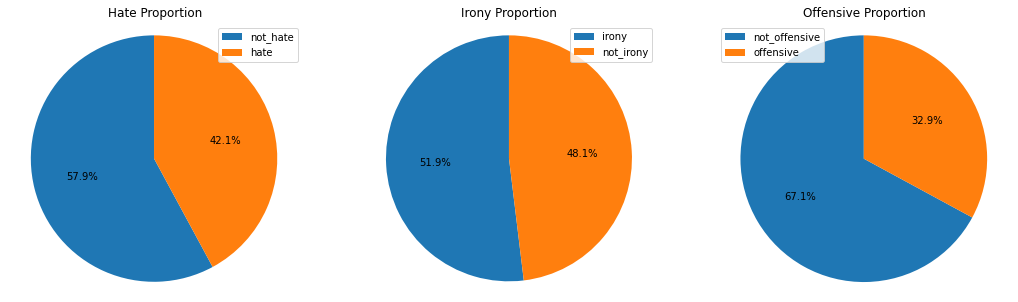

In [4]:
Proportion_chart(df_hate,hate,not_hate,df_irony,irony,not_irony,df_offensive,offensive,not_offensive)

In [5]:
hate_dict_train = imbalance_under_sampling(hate_dict_train)
irony_dict_train = imbalance_under_sampling(irony_dict_train)
offensive_dict_train = imbalance_under_sampling(offensive_dict_train)

#Downloading Models and Tokenizations from HuggingFace

In [6]:
from transformers import TFXLNetModel, XLNetTokenizer, TFDistilBertModel, DistilBertTokenizer

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

for layer in xlnet_model.layers:
    layer.trainable = True
for layer in dbert_model.layers:
    layer.trainable = True

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#Word Embeddings using XLNet tokenizier, which consist of tokens and attention masks

In [7]:
#DistilBert Tokenizer
dl_hate_train_input = get_tokenization(hate_dict_train['text'], dbert_tokenizer)
dl_hate_val_input = get_tokenization(hate_dict_val['text'], dbert_tokenizer)
dl_hate_test_input = get_tokenization(hate_dict_test['text'], dbert_tokenizer)

dl_irony_train_input = get_tokenization(irony_dict_train['text'], dbert_tokenizer)
dl_irony_val_input = get_tokenization(irony_dict_val['text'], dbert_tokenizer)
dl_irony_test_input = get_tokenization(irony_dict_test['text'], dbert_tokenizer)

dl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
dl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
dl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

#XLNet Tokenizer
xl_hate_train_input = get_tokenization(hate_dict_train['text'], xlnet_tokenizer)
xl_hate_val_input = get_tokenization(hate_dict_val['text'], xlnet_tokenizer)
xl_hate_test_input = get_tokenization(hate_dict_test['text'], xlnet_tokenizer)

xl_irony_train_input = get_tokenization(irony_dict_train['text'], xlnet_tokenizer)
xl_irony_val_input = get_tokenization(irony_dict_val['text'], xlnet_tokenizer)
xl_irony_test_input = get_tokenization(irony_dict_test['text'], xlnet_tokenizer)

xl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
xl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
xl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

#Apply DistilBert as the 1st model to predict classifcation.


In [8]:
DistilBert_hate = create_model(dbert_model)
DistilBert_hate.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

#CallBacks for all attempts of training

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [10]:
hist_dl_hate = DistilBert_hate.fit(x=dl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 70s 133ms/step - loss: 0.6211 - accuracy: 0.6406 - precision: 0.6371 - recall: 0.6657 - val_loss: 0.5531 - val_accuracy: 0.6990 - val_precision: 0.6137 - val_recall: 0.7963
Epoch 2/25
473/473 [==============================] - 61s 129ms/step - loss: 0.4086 - accuracy: 0.8229 - precision: 0.8158 - recall: 0.8381 - val_loss: 0.6138 - val_accuracy: 0.7120 - val_precision: 0.6160 - val_recall: 0.8642
Epoch 3/25
473/473 [==============================] - 61s 129ms/step - loss: 0.2372 - accuracy: 0.9035 - precision: 0.8919 - recall: 0.9196 - val_loss: 0.6697 - val_accuracy: 0.7280 - val_precision: 0.6585 - val_recall: 0.7541
Epoch 4/25
473/473 [==============================] - 61s 129ms/step - loss: 0.1249 - accuracy: 0.9537 - precision: 0.9495 - recall: 0.9584 - val_loss: 0.8014 - val_accuracy: 0.7240 - val_precision: 0.6483 - val_recall: 0.7728
Epoch 5/25
473/473 [==============================] - 61s 129ms/step - loss: 0.0531 - accura

In [11]:
preds_dl_hate = DistilBert_hate.predict(dl_hate_test_input, verbose=True)

93/93 [==============================] - 8s 77ms/step


F1_score of Hate dataset with DistilBert is: 56.2%


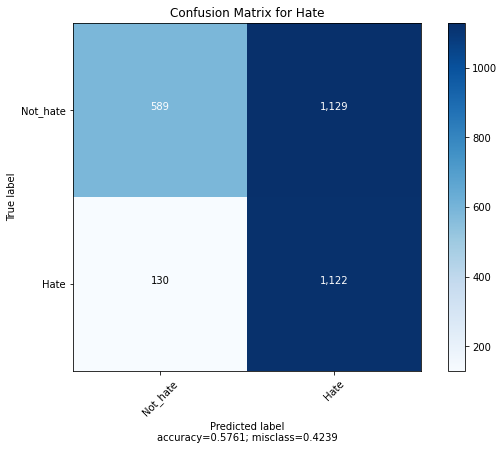

In [12]:
hate_pred_dl_label = [i[0] for i in preds_dl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_dl_label)
f1_dl_hate = f1_score(hate_dict_test.label,hate_pred_dl_label,average='macro')
print("F1_score of Hate dataset with DistilBert is: %.1f%%" % round(f1_dl_hate*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [13]:
DistilBert_irony = create_model(dbert_model)
hist_irony = DistilBert_irony.fit(x=dl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 33s 146ms/step - loss: 0.7092 - accuracy: 0.5043 - precision_1: 0.5042 - recall_1: 0.5677 - val_loss: 0.6479 - val_accuracy: 0.6251 - val_precision_1: 0.6038 - val_recall_1: 0.6250
Epoch 2/25
178/178 [==============================] - 24s 137ms/step - loss: 0.5865 - accuracy: 0.6838 - precision_1: 0.6952 - recall_1: 0.6813 - val_loss: 0.6234 - val_accuracy: 0.6471 - val_precision_1: 0.6343 - val_recall_1: 0.6162
Epoch 3/25
178/178 [==============================] - 24s 138ms/step - loss: 0.3949 - accuracy: 0.8136 - precision_1: 0.8374 - recall_1: 0.7739 - val_loss: 0.7431 - val_accuracy: 0.6335 - val_precision_1: 0.5858 - val_recall_1: 0.7939
Epoch 4/25
178/178 [==============================] - 24s 138ms/step - loss: 0.1840 - accuracy: 0.9338 - precision_1: 0.9313 - recall_1: 0.9305 - val_loss: 0.9000 - val_accuracy: 0.6471 - val_precision_1: 0.6197 - val_recall_1: 0.6754
Epoch 5/25
178/178 [==============================] - 25s 13

In [14]:
preds_dl_irony = DistilBert_irony.predict(dl_irony_test_input, verbose=True)

25/25 [==============================] - 3s 76ms/step


F1_score of irony dataset with DistilBert is: 64.3%


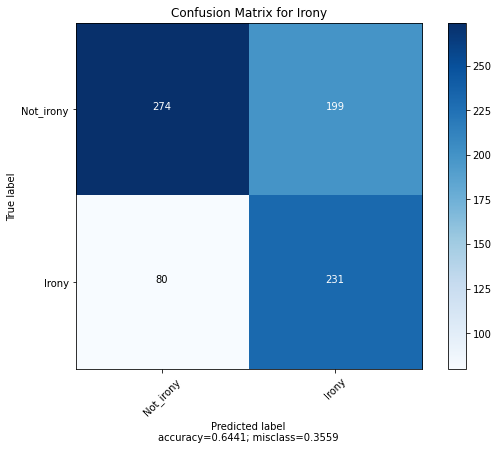

In [15]:
irony_pred_dl_label = [i[0] for i in preds_dl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_dl_label)
f1_dl_irony = f1_score(irony_dict_test.label,irony_pred_dl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_dl_irony*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="Confusion Matrix for Irony")

In [16]:
DistilBert_offensive = create_model(dbert_model)
hist_dl_offensive = DistilBert_offensive.fit(x=dl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 73s 134ms/step - loss: 0.6998 - accuracy: 0.5172 - precision_2: 0.5183 - recall_2: 0.5501 - val_loss: 0.6898 - val_accuracy: 0.5431 - val_precision_2: 0.4087 - val_recall_2: 0.7124
Epoch 2/25
493/493 [==============================] - 64s 130ms/step - loss: 0.6666 - accuracy: 0.5793 - precision_2: 0.5940 - recall_2: 0.5182 - val_loss: 0.6817 - val_accuracy: 0.6261 - val_precision_2: 0.4746 - val_recall_2: 0.7320
Epoch 3/25
493/493 [==============================] - 64s 130ms/step - loss: 0.5814 - accuracy: 0.6804 - precision_2: 0.7186 - recall_2: 0.6125 - val_loss: 0.5585 - val_accuracy: 0.7364 - val_precision_2: 0.6858 - val_recall_2: 0.4423
Epoch 4/25
493/493 [==============================] - 64s 131ms/step - loss: 0.4774 - accuracy: 0.7790 - precision_2: 0.7885 - recall_2: 0.7670 - val_loss: 0.7366 - val_accuracy: 0.6427 - val_precision_2: 0.4898 - val_recall_2: 0.7342
Epoch 5/25
493/493 [==============================] - 64s 13

In [17]:
preds_dl_offensive = DistilBert_offensive.predict(dl_offensive_test_input, verbose=True)

27/27 [==============================] - 4s 76ms/step


F1_score of offensive dataset with DistilBert is: 66.1%


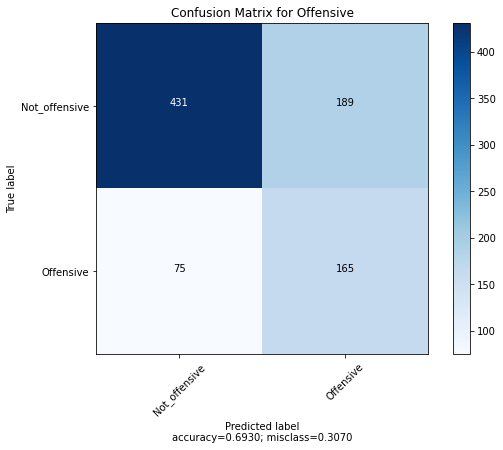

In [18]:
offensive_pred_dl_label = [i[0] for i in preds_dl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_dl_label)
f1_dl_offensive = f1_score(offensive_dict_test.label,offensive_pred_dl_label,average='macro')
print("F1_score of offensive dataset with DistilBert is: %.1f%%" % round(f1_dl_offensive*100,1))
plot_confusion_matrix(cm, normalize=False, target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for Offensive")

#Apply XLNet as the 2nd model to predict classifcation.

In [19]:
XLNet_hate = create_model(xlnet_model)
XLNet_hate.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ids (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
word_attention (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model (TFXLNetModel)   TFXLNetModelOutput(l 116718336   word_ids[0][0]                   
                                                                 word_attention[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 1, 768)       0           tfxl_net_model[0][0]       

In [20]:
hist_xl_hate = XLNet_hate.fit(x=xl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 161s 315ms/step - loss: 0.7194 - accuracy: 0.5775 - precision_3: 0.5777 - recall_3: 0.5968 - val_loss: 0.5855 - val_accuracy: 0.7030 - val_precision_3: 0.6578 - val_recall_3: 0.6347
Epoch 2/25
473/473 [==============================] - 146s 310ms/step - loss: 0.5100 - accuracy: 0.7555 - precision_3: 0.7465 - recall_3: 0.7631 - val_loss: 0.5669 - val_accuracy: 0.7120 - val_precision_3: 0.6299 - val_recall_3: 0.7892
Epoch 3/25
473/473 [==============================] - 147s 310ms/step - loss: 0.4197 - accuracy: 0.8227 - precision_3: 0.8151 - recall_3: 0.8346 - val_loss: 0.6005 - val_accuracy: 0.7250 - val_precision_3: 0.6357 - val_recall_3: 0.8337
Epoch 4/25
473/473 [==============================] - 146s 310ms/step - loss: 0.3210 - accuracy: 0.8685 - precision_3: 0.8543 - recall_3: 0.8870 - val_loss: 0.6563 - val_accuracy: 0.7300 - val_precision_3: 0.6561 - val_recall_3: 0.7728
Epoch 5/25
473/473 [==============================] - 14

In [21]:
preds_xl_hate = XLNet_hate.predict(xl_hate_test_input, verbose=True)

93/93 [==============================] - 19s 184ms/step


F1_score of Hate dataset with XLnet is: 56.9%


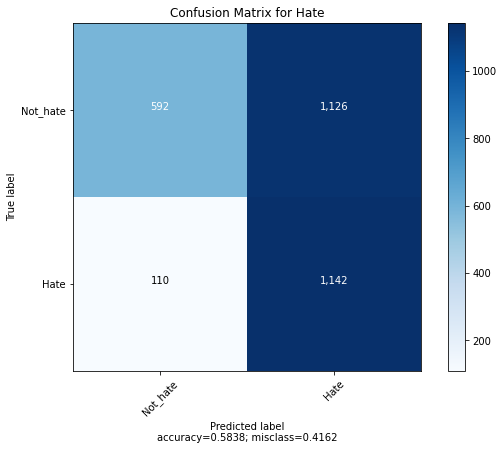

In [22]:
hate_pred_xl_label = [i[0] for i in preds_xl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_xl_label)
f1_xl_hate = f1_score(hate_dict_test.label,hate_pred_xl_label,average='macro')
print("F1_score of Hate dataset with XLnet is: %.1f%%" % round(f1_xl_hate*100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [23]:
XLNet_irony = create_model(xlnet_model)

In [24]:
hist_xl_irony = XLNet_irony.fit(x=xl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 72s 340ms/step - loss: 1.0901 - accuracy: 0.5049 - precision_4: 0.4991 - recall_4: 0.4882 - val_loss: 0.6912 - val_accuracy: 0.5288 - val_precision_4: 0.5238 - val_recall_4: 0.1447
Epoch 2/25
178/178 [==============================] - 58s 328ms/step - loss: 0.6963 - accuracy: 0.5328 - precision_4: 0.5376 - recall_4: 0.4912 - val_loss: 0.6757 - val_accuracy: 0.5696 - val_precision_4: 0.5672 - val_recall_4: 0.4167
Epoch 3/25
178/178 [==============================] - 58s 328ms/step - loss: 0.6746 - accuracy: 0.5856 - precision_4: 0.5906 - recall_4: 0.5549 - val_loss: 0.6606 - val_accuracy: 0.6084 - val_precision_4: 0.5756 - val_recall_4: 0.6842
Epoch 4/25
178/178 [==============================] - 58s 328ms/step - loss: 0.5825 - accuracy: 0.6980 - precision_4: 0.7029 - recall_4: 0.6846 - val_loss: 0.6298 - val_accuracy: 0.6471 - val_precision_4: 0.6715 - val_recall_4: 0.5110
Epoch 5/25
178/178 [==============================] - 58s 32

In [25]:
preds_xl_irony = XLNet_irony.predict(xl_irony_test_input, verbose=True)

25/25 [==============================] - 6s 181ms/step


F1_score of irony dataset with DistilBert is: 66.3%


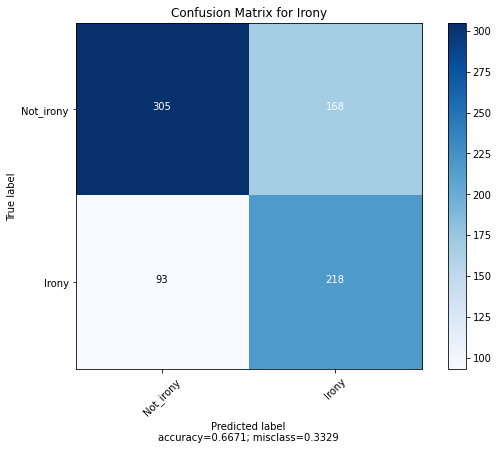

In [26]:
irony_pred_xl_label = [i[0] for i in preds_xl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_xl_label)
f1_xl_irony = f1_score(irony_dict_test.label,irony_pred_xl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_xl_irony * 100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="Confusion Matrix for Irony")

In [27]:
XLNet_offensive = create_model(xlnet_model)

In [28]:
hist_xl_offensive = XLNet_offensive.fit(x=xl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 168s 317ms/step - loss: 0.6825 - accuracy: 0.6174 - precision_5: 0.6143 - recall_5: 0.6164 - val_loss: 0.4952 - val_accuracy: 0.7817 - val_precision_5: 0.6628 - val_recall_5: 0.7538
Epoch 2/25
493/493 [==============================] - 154s 313ms/step - loss: 0.4627 - accuracy: 0.7871 - precision_5: 0.7834 - recall_5: 0.7979 - val_loss: 0.4902 - val_accuracy: 0.7583 - val_precision_5: 0.6108 - val_recall_5: 0.8344
Epoch 3/25
493/493 [==============================] - 154s 313ms/step - loss: 0.3419 - accuracy: 0.8593 - precision_5: 0.8467 - recall_5: 0.8754 - val_loss: 0.4843 - val_accuracy: 0.7802 - val_precision_5: 0.6567 - val_recall_5: 0.7669
Epoch 4/25
493/493 [==============================] - 154s 313ms/step - loss: 0.2191 - accuracy: 0.9207 - precision_5: 0.9214 - recall_5: 0.9215 - val_loss: 0.7134 - val_accuracy: 0.7356 - val_precision_5: 0.5817 - val_recall_5: 0.8453
Epoch 5/25
493/493 [==============================] - 15

In [29]:
preds_xl_offensive = XLNet_offensive.predict(xl_offensive_test_input, verbose=True)

27/27 [==============================] - 7s 184ms/step


F1_score of offensive dataset with XLNET is: 77.1%


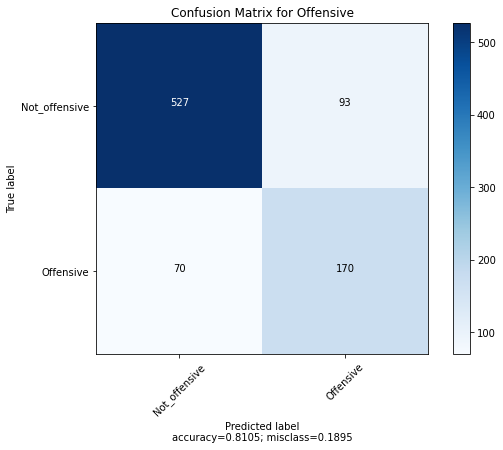

In [30]:
offensive_pred_xl_label = [i[0] for i in preds_xl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_xl_label)
f1_xl_offensive = f1_score(offensive_dict_test.label,offensive_pred_xl_label,average='macro')
print("F1_score of offensive dataset with XLNET is: %.1f%%" % round(f1_xl_offensive * 100,1))
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for Offensive")

#Report for comparing the result

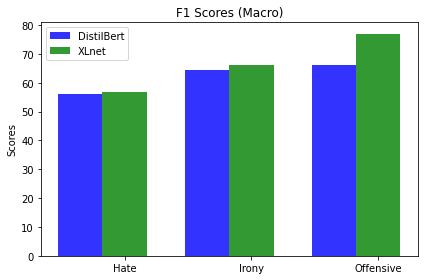

In [31]:
f1_score_bar(f1_dl_hate,f1_dl_irony,f1_dl_offensive,f1_xl_hate,f1_xl_irony,f1_xl_offensive)    

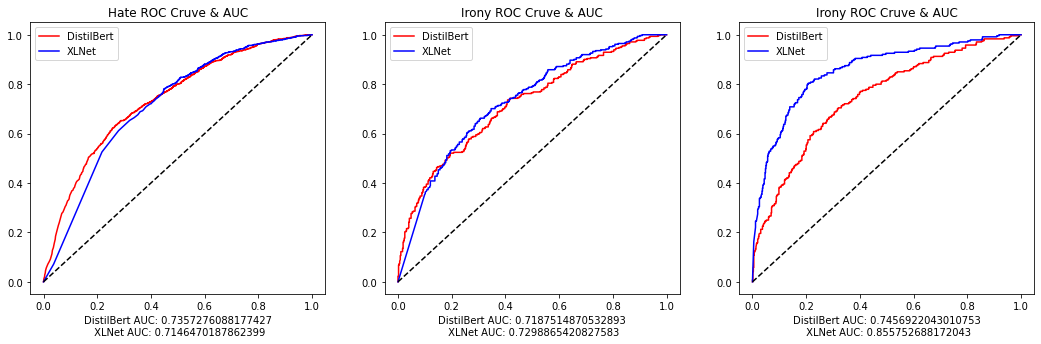

In [32]:
auc_plot_metrics(preds_dl_hate, preds_xl_hate, hate_dict_test.label,
         preds_dl_irony, preds_xl_irony, irony_dict_test.label,
         preds_dl_offensive, preds_xl_offensive, offensive_dict_test.label)